In [1]:
# Library Imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import ipywidgets as widgets
import numpy as np
%matplotlib notebook

In [2]:
# Signal class to generate function points and hold signal parameters
class Signal:
    def __init__(self, function, color, descp):
        self.function = function
        self.color = color
        self.amplitude = 1
        self.attenuation = 0
        self.frequency = 1
        self.patch = mpatches.Patch(color=self.color, label=descp)
        
    def update(self, params):
        self.amplitude = params.get("Amplitude", self.amplitude)
        self.attenuation = params.get("Attenuation", self.attenuation)
        self.frequency = params.get("Frequency", self.frequency)
        
    # Generate points to plot, discrete function is handled by bootstrapping on continuous variables
    def generate_points(self, time_values):
        if len(time_values) < 50:
            return np.power(self.attenuation, time_values) * self.function(self.frequency * time_values)
        else:
            return self.amplitude * np.exp(self.attenuation * time_values) * self.function(np.pi * self.frequency * time_values)

In [3]:
# Slider class to combine slide and play handler
class Slider:
    def __init__(self, call_back, descp, default_val=0, minimum=0, maximum=10):
        self.player = widgets.Play(min=minimum, interval=1000, value=default_val)
        self.slider = widgets.IntSlider(description=descp, min=minimum, max=maximum, step=1, continuous_update=True)
        self.link(call_back)
  
    def link(self, on_value_change):
        self.slider.observe(on_value_change, 'value')
        widgets.jslink((self.player, 'value'), (self.slider, 'value'))

In [4]:
from matplotlib.patches import Circle
# Graph class to hold all plotting variables
class Graph:
    def __init__(self, slider_list, function_list, interval=0.001, llimit=0, ulimit=10):
        self.sliders = [Slider(self.call_back, *slide) for slide in slider_list]
        self.functions = [Signal(*funct) for funct in function_list]
        self.time_values = np.arange(llimit, ulimit, interval)
        
        display(widgets.VBox([widgets.HBox([slide.slider, slide.player]) for slide in self.sliders]))
        
        # Connect figure to click event
        self.fig = plt.figure()
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        
        self.ax = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
        self.ax.axis([llimit, ulimit, -10, 10])
        self.ax.grid(True)
        self.ax.set_ylabel("Amplitude")
        self.ax.axhline(0, linewidth=1, color='black')
        self.ax.axvline(0, linewidth=1, color='black')
        self.ax.legend(handles=[funct.patch for funct in self.functions])
        
        # Create crosshair
        self.controls = plt.subplot2grid((3,3), (1,2))
        self.controls.axis([-1.5, 1.5, -1.1, 1.1])
        # Move left y-axis and bottim x-axis to centre, passing through (0,0)
        self.controls.spines['left'].set_position('center')
        self.controls.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        self.controls.spines['right'].set_color('none')
        self.controls.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        self.controls.xaxis.set_ticks_position('bottom')
        self.controls.yaxis.set_ticks_position('left')
        
        self.controls.add_patch(Circle((0, 0), 1, color="grey", fill=True, alpha=0.5))
        self.controls.xaxis.set_label_coords(1, 0.5)
        self.controls.yaxis.set_label_coords(0.5, 1.2)
        
        # Titles based on plot types
        if interval < 0.5:
            self.ax.set_title(r'Real and imaginary components of $e^{st}$')
            self.controls.set_xlabel("Re[s]")
            self.controls.set_ylabel("Im[s]")
        else:
            self.ax.set_title(r'Real and imaginary components of $z^{n}$')
            self.controls.set_xlabel("Re[z]")
            self.controls.set_ylabel("Im[z]")

        self.plot()
        
    def plot(self):
        self.grid = []
        params = {} if len(self.time_values) > 1500 else {'marker':'.', 'linestyle':'None'}
        for funct in self.functions:
            self.grid += self.ax.plot(self.time_values, funct.generate_points(self.time_values), color=funct.color, **params)
        
    def clear(self):
        for i in self.grid:
            i.remove()
    
    # Slider event handler
    def call_back(self, change):
        new_change = {change["owner"].description : change["new"]}
        for funct in self.functions:
            funct.update(new_change)
        print(new_change)
        self.clear()
        self.plot()
    
    # Click event handler
    def onclick(self, event):
        if event.inaxes == self.controls:
            if len(self.time_values) < 50:
                # Create complex magnitude and angle
                x = np.sqrt(event.xdata*event.xdata + event.ydata*event.ydata)
                y = np.angle(event.xdata+event.ydata*1j)
            else:
                x = event.xdata
                y = event.ydata
            new_change = {"Attenuation" : x, "Frequency" : y}
            for funct in self.functions:
                funct.update(new_change)
            self.clear()
            self.plot()
            self.grid += self.controls.plot(event.xdata, event.ydata, marker='*', color="black")

VBox()

<IPython.core.display.Javascript object>


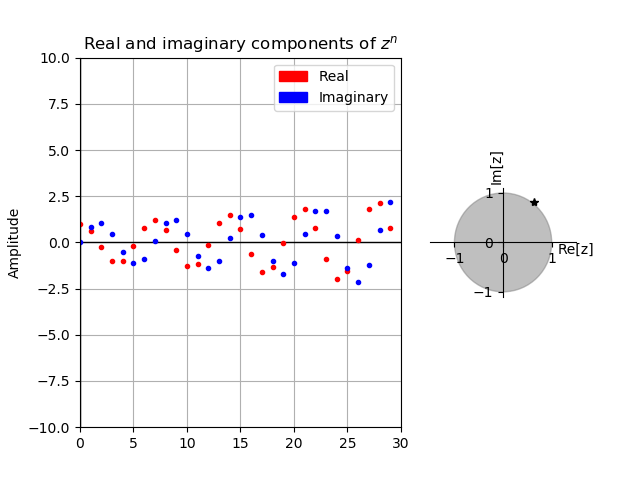

In [5]:
# Discrete Time Complex Exponential
%matplotlib notebook
dcrt_cplx = Graph([], [[np.cos, "red", "Real"], [np.sin, "blue", "Imaginary"]], 1, ulimit=30)

<IPython.core.display.Javascript object>


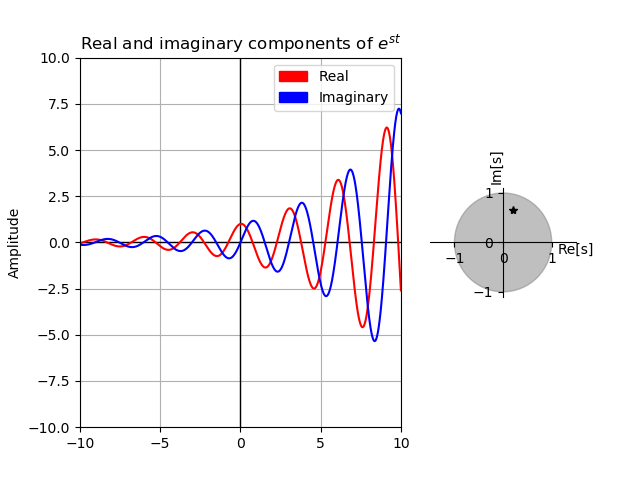

In [6]:
# Continuous Time Complex Exponential
cont_cplx = Graph([["Amplitude", 1]], [[np.cos, "red", "Real"], [np.sin, "blue", "Imaginary"]], llimit=-10)